<p><span style="color: #ffff99;">The __future__ module in Python&nbsp;<strong>allows you to enable new language features which are not compatible with the current version of Python</strong>. These features are typically included in the next version of Python, but can be used in the current version by importing the __future__ module and enabling them</span></p>

<p><span style="color: #ffff99;">what is momentum in batch normalization&nbsp;</span></p>
<p><span style="color: #ffff99;">to be searched</span></p>

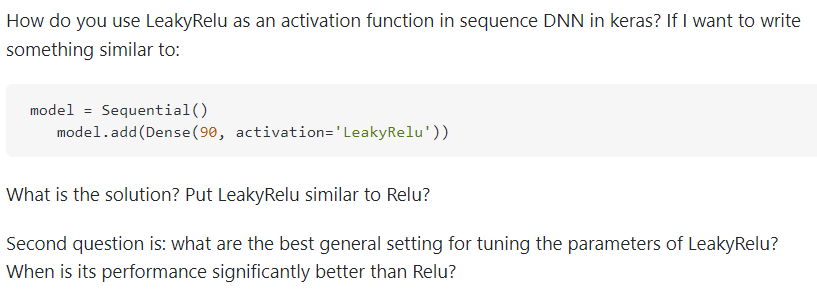
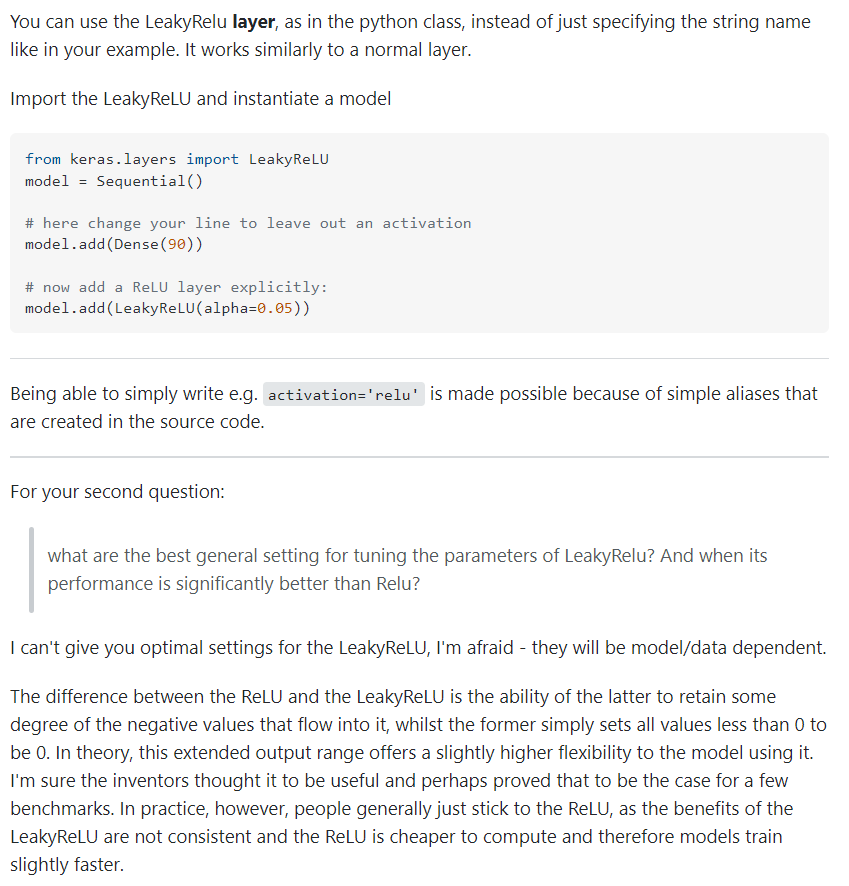

<h3><span style="color: #ffcc99;">the goal is creating a dataset like mnist</span></h3>

<h3><span style="color: #99ccff;">both generator and discriminator should be at same power,if one of them uses pretrained model the other one also should use pretrained model</span></h3>

In [1]:

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
# from keras.layers.advanced_activations import LeakyReLU
from keras.layers import LeakyReLU

from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np


<h2><span style="color: #ffff99;">generator</span></h2>

In [2]:

#Define input image dimensions
#Large images take too much time and resources.
img_rows = 28   #here images are grayscale,but we add channel for future use for RGB colored images
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

##########################################################################
#Given input of noise (latent) vector, the Generator produces an image.
def build_generator():

    noise_shape = (100,) #1D array of size 100 (latent vector / noise)

    #Define your generator network 
    #Here we are only using Dense layers. But network can be complicated based
    #on the application. For example, you can use VGG for super res. GAN.         

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8)) #momentum controls how fast it is trained
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image

    return Model(noise, img)    #noise is input to generator and generator returnes the created image

#Alpha — α is a hyperparameter which controls the underlying value to which the
#function saturates negatives network inputs.
#Momentum — Speed up the training
##########################################################################


In [3]:
idx = np.random.randint(0,20,5)
idx

array([19,  0, 13, 15, 13])

<h2><span style="color: #ffff99;">discriminator</span></h2>

In [4]:

#Given an input image, the Discriminator outputs the likelihood of the image being real.
    #Binary classification - true or false (we're calling it validity)

def build_discriminator():  


    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity) #and also outputs the image we suppplyed
#The validity is the Discriminator’s guess of input being real or not.



<h2><span style="color: #ffff99;">train</span></h2>

In [8]:

#Now that we have constructed our two models it’s time to put them against each other.
#We do this by defining a training function, loading the data set, re-scaling our training
#images and setting the ground truths. 
def train(epochs, batch_size=128, save_interval=50):    #save_interval:how often do you want to save

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data(path='D:\CSV original\mnist.npz')    #X_train is unsigned int values between 0 and 255

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5 #X_train is 28*28

    #Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3) 

    half_batch = int(batch_size / 2)    #we want to input half batch number of real images alongside half batch fake images to discriminator 


    #We then loop through a number of epochs to train our Discriminator by first selecting
    #a random batch of images from our true dataset, generating a set of images from our
    #Generator, feeding both set of images into our Discriminator, and finally setting the
    #loss parameters for both the real and fake images, as well as the combined loss. 
    
    for epoch in range(epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

 
        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        #Research showed that separate training is more effective. 
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))  #label of real images should be 1
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))) #label of fake images should be 0
        #take average loss from real and fake images to get a single loss
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 

        #And within the same loop we train our Generator, by setting the input noise and
        #ultimately training the Generator to have the Discriminator label its samples as valid
        #by specifying the gradient loss.
        # ---------------------
        #  Train Generator
        # ---------------------
        #Create noise vectors as input for generator. 
        #Create as many noise vectors as defined by the batch size. 
        #Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100)) 

        # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the genrator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y) in other words we re calling fake images to be true
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size
        #valid_y will be label for these fake images that are to be 1 
        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y. 
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of fooling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


        #Additionally, in order for us to keep track of our training process, we print the
        #progress and save the sample image output depending on the epoch interval specified.  
        # Plot the progress
        
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))    #printing the epoch,discriminator loss,discriminator accuracy

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

        #when the specific sample_interval is hit, we call the
        #save_imgs function. Which looks as follows.


<h2><span style="color: #ffff99;">saving images</span></h2>

In [6]:

def save_imgs(epoch):
    r, c = 5, 5 #to create 5*5 grid images,totally 25 images out of predicted ones
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("images/mnist_%d.png" % epoch)
    plt.close()
#This function saves our images for us to view



<h2><span style="color: #ffff99;">main</span></h2>

In [11]:

##############################################################################

#Let us also define our optimizer for easy use later on.
#That way if you change your mind, you can change it easily here
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first. 
#Generator will be trained as part of the combined model, later. 
#pick the loss function and the type of metric to keep track.                 
#Binary cross entropy as we are doing prediction and it is a better
#loss function compared to MSE or other. 
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

#build and compile our Discriminator, pick the loss function

#SInce we are only generating (fake) images, let us not track any metrics.
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

##This builds the Generator and defines the input noise. 
#In a GAN the Generator network takes noise z as an input to produce its images.  
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

#This ensures that when we combine our networks we only train the Generator.
#While generator training we do not want discriminator weights to be adjusted. 
#This Doesn't affect the above descriminator training.     
discriminator.trainable = False  

#This specifies that our Discriminator will take the images generated by our Generator
#and true dataset and set its output to a parameter called valid, which will indicate
#whether the input is real or not.  
valid = discriminator(img)  #Validity check on the generated image


#Here we combined the models and also set our loss function and optimizer. 
#Again, we are only training the generator here. 
#The ultimate goal here is for the Generator to fool the Discriminator.  
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)


train(epochs=10000, batch_size=32, save_interval=100)

#Save model for future use to generate fake images
#Not tested yet... make sure right model is being saved..
#Compare with GAN4

generator.save('generator_model.h5')  #Test the model on GAN4_predict...
#Change epochs back to 30K
                
#Epochs dictate the number of backward and forward propagations, the batch_size
#indicates the number of training samples per backward/forward propagation, and the
#sample_interval specifies after how many epochs we call our sample_image function.

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_21 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_22 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_23 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

<h3><span style="color: #ffff99;">generated images after 100,1000,5000,10000 epochs:</span></h3>

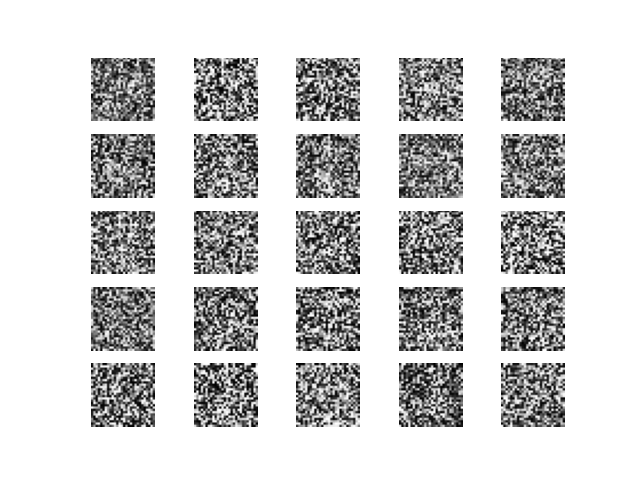

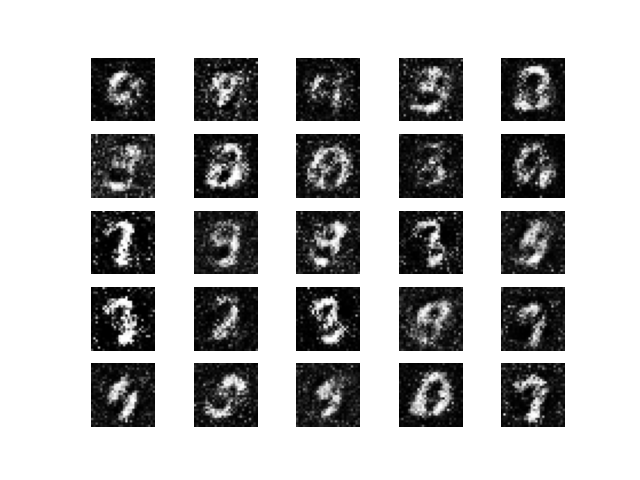

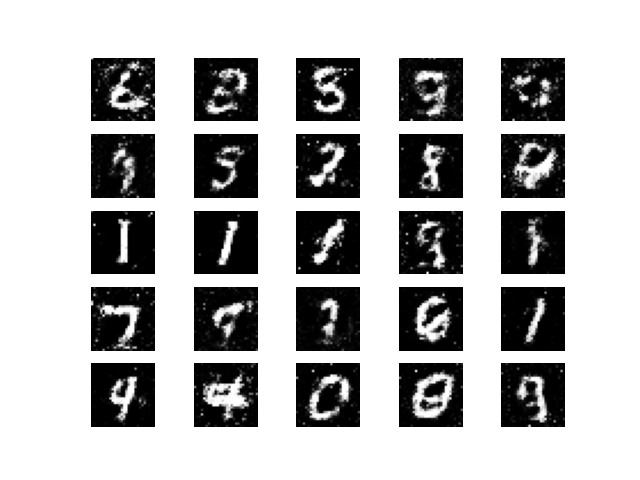

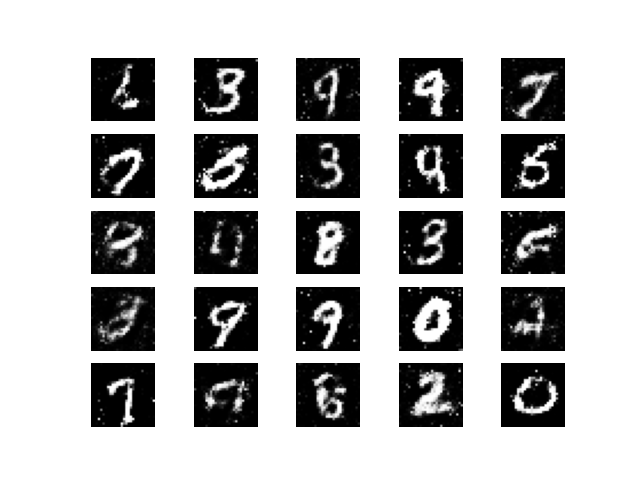